<a href="https://colab.research.google.com/github/angrybird210/specrom_analytics/blob/main/Specrom_analytics_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing libraries**

In [11]:
!pip install geopandas
!pip install geopy
!pip install folium

     |████████████████████████████████| 1.0MB 5.9MB/s 
     |████████████████████████████████| 6.5MB 17.9MB/s 
     |████████████████████████████████| 14.8MB 293kB/s 


In [12]:
from geopy.geocoders import Nominatim
import pandas as pd
import folium
from folium.plugins import FastMarkerCluster
from folium.plugins import MarkerCluster

from branca.element import Figure
fig=Figure(width=800,height=800)

In [13]:
#check
locator = Nominatim(user_agent='myGeoCoder')
location = locator.geocode('Champ de Mars, Paris, France')
if location==None:
  print('Champ de Mars, nsackjas Paris, France')
else:
  print('Latitude = {}, Longitude = {}'.format(location.latitude, location.longitude))



Latitude = 48.85614465, Longitude = 2.297820393322227


In [14]:
df = pd.read_csv("specrom_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   address_line_1  59 non-null     object
 1   address_line_2  37 non-null     object
 2   city            59 non-null     object
 3   name            59 non-null     object
 4   phone           59 non-null     object
 5   state           57 non-null     object
 6   url             59 non-null     object
 7   zip_code        59 non-null     int64 
 8   address         59 non-null     object
 9   Updated_Date    59 non-null     object
dtypes: int64(1), object(9)
memory usage: 4.7+ KB


**Preprocessing data to get latitudes and longitudes**

In [15]:
#filling missing values of state with country name
df['state'] = df['state'].fillna("US")
df.head()

,address_line_1,address_line_2,city,name,phone,state,url,zip_code,address,Updated_Date
0,4500 N Oracle Road,Space 115,Tucson,Tucson Mall,(520) 888-0336,AZ,https://stores.ladyfootlocker.com/us/az/tucson...,85705,"4500 N Oracle Road, Space 115, Tucson, AZ, 85705",2021-02-28
1,14200 E Alameda Ave,Space 2055,Aurora,Town Center At Aurora,(303) 363-8068,CO,https://stores.ladyfootlocker.com/us/co/aurora...,80012,"14200 E Alameda Ave, Space 2055, Aurora, CO, 8...",2021-02-28
2,1450 Ala Moana Blvd,Space 1231,Honolulu,Ala Moana Center,(808) 942-1071,HI,https://stores.ladyfootlocker.com/us/hi/honolu...,96814,"1450 Ala Moana Blvd, Space 1231, Honolulu, HI,...",2021-02-28
3,96 River Oaks Dr,NaN,Calumet City,River Oaks Center,(708) 868-6229,IL,https://stores.ladyfootlocker.com/us/il/calume...,60409,"96 River Oaks Dr, Calumet City, IL, 60409",2021-02-28
4,6401 Bluebonnet Blvd,Space 2114,Baton Rouge,Mall Of Louisiana,(225) 767-2198,LA,https://stores.ladyfootlocker.com/us/la/baton-...,70836,"6401 Bluebonnet Blvd, Space 2114, Baton Rouge,...",2021-02-28


In [16]:
#generating address_data column to pass to geopy
df['zip_code'] = df['zip_code'].apply(str)
df['address_data'] = df[['address_line_1', 'city', 'state', 'zip_code']].agg(','.join, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   address_line_1  59 non-null     object
 1   address_line_2  37 non-null     object
 2   city            59 non-null     object
 3   name            59 non-null     object
 4   phone           59 non-null     object
 5   state           59 non-null     object
 6   url             59 non-null     object
 7   zip_code        59 non-null     object
 8   address         59 non-null     object
 9   Updated_Date    59 non-null     object
 10  address_data    59 non-null     object
dtypes: object(11)
memory usage: 5.2+ KB


In [17]:
from geopy.extra.rate_limiter import RateLimiter
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
df['location'] = df['address_data'].apply(geocode)
df['point'] = df['location'].apply(lambda loc: tuple(loc.point) if loc else None)

In [36]:
#using only city data for locations not found
missing_count=0
for l in df['point']:
  if l==None:
    missing_count+=1
    df['location'] = (df[['city', 'state', 'zip_code']].agg(','.join, axis=1)).apply(geocode)


In [37]:
print('Number of stores for whom latitude and longitude could not be found is %d ' % missing_count)

Number of stores for whom latitude and longitude could not be found is 13 


In [38]:
df['point'] = df['location'].apply(lambda loc: tuple(loc.point) if loc else None)
df['point']

0                   (32.2228765, -110.9748477, 0.0)
1                    (39.729432, -104.8319196, 0.0)
2                    (21.304547, -157.8556764, 0.0)
3                     (41.616016, -87.5295837, 0.0)
4     (30.387688478432157, -91.08695006192694, 0.0)
5                     (42.2097963, -71.001075, 0.0)
6                    (42.4333367, -82.9238847, 0.0)
7             (38.6529545, -90.24111656024635, 0.0)
8                   (39.5261206, -119.8126581, 0.0)
9      (35.85031147305154, -78.69450108839244, 0.0)
10                   (41.6529143, -83.5378173, 0.0)
11    (40.657478049999995, -75.50746464724347, 0.0)
12                    (34.851354, -82.3984882, 0.0)
13             (38.9317403, -77.1670637790478, 0.0)
14                   (34.0211224, -118.396466, 0.0)
15                  (36.7394421, -119.7848307, 0.0)
16                  (34.1469416, -118.2478471, 0.0)
17                  (37.6390972, -120.9968782, 0.0)
18                  (38.5810606, -121.4938951, 0.0)
19          

In [39]:
df['point'] = df['location'].apply(lambda loc: tuple(loc.point) if loc else None)
df[['latitude', 'longitude', 'altitude']] = pd.DataFrame(df['point'].tolist(), index=df.index)
df = df.drop(['point','altitude','address_line_2','address_data'],axis = 1)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   address_line_1  59 non-null     object 
 1   city            59 non-null     object 
 2   name            59 non-null     object 
 3   phone           59 non-null     object 
 4   state           59 non-null     object 
 5   url             59 non-null     object 
 6   zip_code        59 non-null     object 
 7   address         59 non-null     object 
 8   Updated_Date    59 non-null     object 
 9   location        59 non-null     object 
 10  latitude        59 non-null     float64
 11  longitude       59 non-null     float64
dtypes: float64(2), object(10)
memory usage: 5.7+ KB


# figure 1: create a US map with store locations as markers

In [42]:
#tap on markers to get name of that store

df_text = df[['name']]

xlat = df['latitude'].tolist()
xlon = df['longitude'].tolist()
locations = list(zip(xlat, xlon))
map2 = folium.Map(location=[37.893723,-97.896319],zoom_start = 5,tiles = 'CartoDB dark_matter')
marker_cluster = MarkerCluster().add_to(map2)
try:
   for point in range(0, len(locations)):
      folium.Marker(locations[point], popup = folium.Popup(df_text['name'] 
      [point])).add_to(marker_cluster)    
except:
   pass
map2

In [50]:
#saving map as png
map2.save('index.html')

# figure 2: draw a horizontal bar plot of state names with top 5 locations

In [51]:
# get top 5 most frequent states
n = 5
data_count = df['state'].value_counts()[:n]
data = data_count.index.tolist()
data_count

TX    9
CA    8
NJ    6
GA    5
NY    4
Name: state, dtype: int64

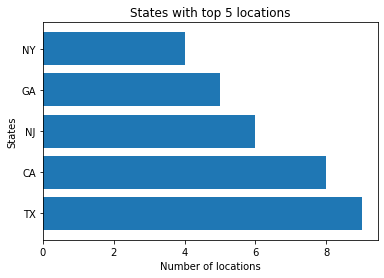

In [52]:
import matplotlib.pyplot as plt
plt.barh(data,data_count[:][:n])
plt.title('States with top 5 locations')
plt.ylabel('States')
plt.xlabel('Number of locations')
plt.show()

# analyzing states where there are no stores

In [53]:
total_states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

In [54]:
states = df['state'].value_counts().index.tolist()
len(states)

25

**Analysis based on given data-**

There are 59 total stores of lady footlocker in US.Out of 51 states,lady footlocker stores are present in 24 states with maximum number stores in Texas.14 states have only one store while 27 states have none.Two entries in the given data have missing value of state.

Number of stores for whom latitude and longitude could not be found is 13 